# Galaxy Classification with CNN (Pytorch)

Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge



References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b72a2b2d-edf2-847b-4356-e292dd44fb9e)


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Unzip images

Before running the code, please upload `images_train.zip`, `images_valid.zip` and `images_test.zip` to the workspace.

We upzip these 3 files:

- training images (n=99,808) in folder `images_train`
- validation images (n=24,952) in folder `images_valid`, and
- test images (n=31,191) in folder `images_test`.

In [3]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

#### Unzip from Google Drive

In [4]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

#### Unzip from Google Colab workspace

In [ ]:
## Unzip training, validation, and test images
unzipping('images_train.zip', 'images_train')
unzipping('images_valid.zip', 'images_valid')
unzipping('images_test.zip', 'images_test')

## Import custom datasets

In [5]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label

## Data Augmentation Transforms

In [6]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

## Parameters

In [7]:
NUM_OF_CLASSES = 8  # there are 8 classes in total
BATCH_SIZE = 64     # batch zize

## Training function

In [8]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
        is_for_inception: True if the model is an inception model
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            if is_for_inception:
                pred_logits, aux_outputs = model(images)
                loss = criterion(pred_logits, labels) + 0.4*criterion(aux_outputs, labels)
            else:
                pred_logits = model(images)
                loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu')

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu')

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))
    # return the best model
    return model, history_dic

## ResNet50 Model

### Model architecture

In [9]:
## Resnet50 architecture
model = models.resnet50(pretrained=True)
print(model)
# count trainable parameters
print("==========")
print("Number of trainable parameters:")
print("layer1: {}".format(sum(param.numel() for param in model.layer1.parameters() if param.requires_grad)))
print("layer2: {}".format(sum(param.numel() for param in model.layer2.parameters() if param.requires_grad)))
print("layer3: {}".format(sum(param.numel() for param in model.layer3.parameters() if param.requires_grad)))
print("layer4: {}".format(sum(param.numel() for param in model.layer4.parameters() if param.requires_grad)))
print("fc: {}".format(sum(param.numel() for param in model.fc.parameters() if param.requires_grad)))
print("TOTAL: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("==========")
# free the space
del model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Create transforms and dataloaders

We set `is_for_inception` to `False`

In [11]:
# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))

Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


### Train

In [12]:
## Download the pre-trained resnet50 model
model = models.resnet50(pretrained=True)

# change the last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)
print(model.fc) # print the modified last layer

print("============")
print("Training")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("============")

# move to gpu
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## train and return the best model
model, history_dic = train_model(model, 200, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False)

# filename to save
filename_prefix = "gz2_resnet50_b64_lr000005_ss10_gamma01_E200_e{}".format(len(history_dic['valid_acc']))

## Save the best weights
torch.save(model.state_dict(), filename_prefix + ".pth")

## Convert history to dataframe
df = pd.DataFrame(history_dic)

## Save the history
df.to_csv(filename_prefix + ".csv")

Linear(in_features=2048, out_features=8, bias=True)
Training
Number of trainable parameters: 23524424


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/200	Train loss: 0.7134	Train acc: 0.7391	Valid loss: 2.0386	Valid acc: 0.3053	Time: 27m 24s	<--
Epoch 2/200	Train loss: 0.5720	Train acc: 0.7921	Valid loss: 2.6842	Valid acc: 0.1119	Time: 26m 48s
Epoch 3/200	Train loss: 0.5385	Train acc: 0.8033	Valid loss: 3.7042	Valid acc: 0.1121	Time: 26m 40s
Epoch 4/200	Train loss: 0.5163	Train acc: 0.8100	Valid loss: 2.2730	Valid acc: 0.3599	Time: 26m 40s	<--
Epoch 5/200	Train loss: 0.4979	Train acc: 0.8165	Valid loss: 1.1808	Valid acc: 0.5545	Time: 26m 36s	<--
Epoch 6/200	Train loss: 0.4867	Train acc: 0.8223	Valid loss: 3.9514	Valid acc: 0.1158	Time: 26m 33s
Epoch 7/200	Train loss: 0.4750	Train acc: 0.8251	Valid loss: 4.7627	Valid acc: 0.0941	Time: 26m 31s
Epoch 8/200	Train loss: 0.4657	Train acc: 0.8278	Valid loss: 3.5408	Valid acc: 0.1189	Time: 26m 32s
Epoch 9/200	Train loss: 0.4573	Train acc: 0.8308	Valid loss: 0.7012	Valid acc: 0.7500	Time: 26m 32s	<--
Epoch 10/200	Train loss: 0.4506	Train acc: 0.8334	Valid loss: 3.8113	Valid acc: 0.08

## Plot History

history_filename: gz2_resnet50_b64_lr000005_ss10_gamma01_E200_e36.csv


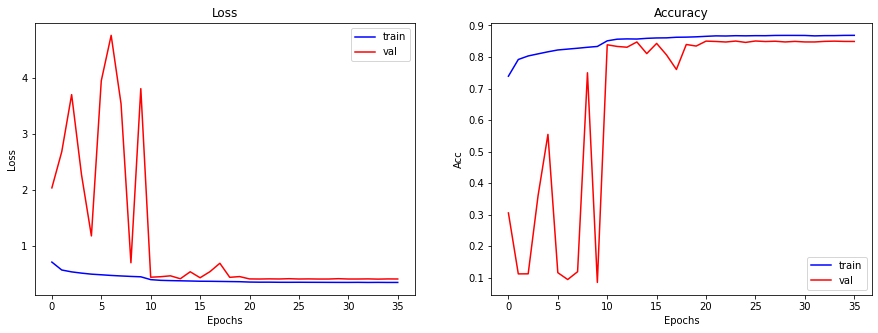

In [13]:
# history filename
history_filename = filename_prefix + ".csv"
print("history_filename: {}".format(history_filename))

# read csv
df = pd.read_csv(history_filename)

# number of epochs
epochs = len(history_dic['valid_acc'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_dic['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_dic['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_dic['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_dic['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()

## Predict Test Data

In [14]:
# weights filename
weights_filename = filename_prefix + ".pth"
print("weights_filename = {}".format(weights_filename))

# download the pre-trained resnet50 model
model = models.resnet50(pretrained=True)

# change the last fc layer
model.fc = nn.Linear(2048, NUM_OF_CLASSES)

# load the weights
model.load_state_dict(torch.load(weights_filename))

# move to gpu
model = model.to(device)

# evaluation
model.eval()

# loss and accuracy
epoch_test_cum_loss = 0.0
epoch_test_cum_corrects = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.long().to(device)

    with torch.no_grad():
        pred_logits = model(images)
        _, pred_classes = torch.max(pred_logits.detach(), dim=1)
        loss = criterion(pred_logits, labels)

        epoch_test_cum_loss += loss.item() * images.size(0)
        epoch_test_cum_corrects += torch.sum(pred_classes==labels.data).detach().cpu()

# calculate final loss and accuracy
test_loss = epoch_test_cum_loss / len(data_test)
test_acc = epoch_test_cum_corrects / len(data_test)

# display
print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.4f}".format(test_acc))

weights_filename = gz2_resnet50_b64_lr000005_ss10_gamma01_E200_e36.pth
Test loss: 0.4108
Test accuracy: 0.8512


In [15]:
import shutil

shutil.move(weights_filename, 'drive/MyDrive/gz2_datasets')
shutil.move(history_filename, 'drive/MyDrive/gz2_datasets')

'drive/MyDrive/gz2_datasets/gz2_resnet50_b64_lr000005_ss10_gamma01_E200_e36.csv'